## Load Data

Yirong, Wentio

In [2]:
import time
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from ridge_utils.ridge import bootstrap_ridge

In [4]:
def load_and_standardize_inplace(story_shapes, x_mean, x_std, y_mean, y_std,
                                 subject_dir, embedding_dir):
    total_len = sum(n_time for (_, n_time, _, _) in story_shapes)
    feat_dim = story_shapes[0][2]
    voxel_dim = story_shapes[0][3]

    X_all = np.empty((total_len, feat_dim), dtype=np.float32)
    Y_all = np.empty((total_len, voxel_dim), dtype=np.float32)

    offset = 0
    for story, n_time, _, _ in story_shapes:
        x_path = os.path.join(embedding_dir, f"{story}.npy")
        y_path = os.path.join(subject_dir, f"{story}.npy")
        X = np.load(x_path, mmap_mode='r')[:n_time]
        Y = np.load(y_path, mmap_mode='r')[:n_time]

        X_z = (X - x_mean) / (x_std + 1e-8)
        Y_z = (Y - y_mean) / (y_std + 1e-8)

        X_all[offset:offset + n_time] = X_z
        Y_all[offset:offset + n_time] = Y_z
        print(f"Processed: {story} | n_time={n_time}")
        offset += n_time

    return X_all, Y_all

def compute_mean_std_manual(story_list, subject_dir, embedding_dir):
    n_total = 0
    x_sum = None
    x_sqsum = None
    y_sum = None
    y_sqsum = None
    valid_shapes = []

    for story in story_list:
        x_path = os.path.join(embedding_dir, f"{story}.npy")
        y_path = os.path.join(subject_dir, f"{story}.npy")
        if not os.path.exists(x_path) or not os.path.exists(y_path):
            continue

        X = np.load(x_path, mmap_mode='r')
        Y = np.load(y_path, mmap_mode='r')
        n_time = min(X.shape[0], Y.shape[0])
        X = X[:n_time]
        Y = Y[:n_time]

        if x_sum is None:
            x_sum = np.zeros(X.shape[1], dtype=np.float64)
            x_sqsum = np.zeros(X.shape[1], dtype=np.float64)
            y_sum = np.zeros(Y.shape[1], dtype=np.float64)
            y_sqsum = np.zeros(Y.shape[1], dtype=np.float64)

        x_sum += X.sum(axis=0)
        x_sqsum += (X ** 2).sum(axis=0)
        y_sum += Y.sum(axis=0)
        y_sqsum += (Y ** 2).sum(axis=0)
        n_total += n_time
        valid_shapes.append((story, n_time, X.shape[1], Y.shape[1]))

    x_mean = x_sum / n_total
    x_std = np.sqrt(x_sqsum / n_total - x_mean**2)
    y_mean = y_sum / n_total
    y_std = np.sqrt(y_sqsum / n_total - y_mean**2)

    return x_mean, x_std, y_mean, y_std, valid_shapes



In [5]:
pwd()

'/ocean/projects/mth240012p/sapountz/lab3_fmri/code'

In [6]:
## Case: subject2, word2vec

subject = "subject2"
embedding_type = "word2vec"
subject_dir = f"../data/{subject}"
embedding_dir = f"../results/embeddings/{embedding_type}"

story_files = [f[:-4] for f in os.listdir(subject_dir) if f.endswith(".npy")]
from sklearn.model_selection import train_test_split
train_stories, test_stories = train_test_split(story_files, test_size=0.2, random_state=42)


In [7]:
time_start = time.time()

x_mean, x_std, y_mean, y_std, train_shapes = compute_mean_std_manual(train_stories, subject_dir, embedding_dir)
X_train_z, Y_train_z = load_and_standardize_inplace(train_shapes, x_mean, x_std, y_mean, y_std, subject_dir, embedding_dir)

_, _, _, _, test_shapes = compute_mean_std_manual(test_stories, subject_dir, embedding_dir)
X_test_z, Y_test_z = load_and_standardize_inplace(test_shapes, x_mean, x_std, y_mean, y_std, subject_dir, embedding_dir)

time_end = time.time()
print(time_end-time_start)

Processed: thesurprisingthingilearnedsailingsoloaroundtheworld | n_time=480
Processed: catfishingstrangerstofindmyself | n_time=326
Processed: gangstersandcookies | n_time=256
Processed: tetris | n_time=280
Processed: againstthewind | n_time=170
Processed: theadvancedbeginner | n_time=318
Processed: leavingbaghdad | n_time=327
Processed: quietfire | n_time=455
Processed: canplanetearthfeedtenbillionpeoplepart2 | n_time=545
Processed: sweetaspie | n_time=157
Processed: gpsformylostidentity | n_time=326
Processed: thesecrettomarriage | n_time=292
Processed: afearstrippedbare | n_time=427
Processed: shoppinginchina | n_time=337
Processed: escapingfromadirediagnosis | n_time=343
Processed: howtodraw | n_time=354
Processed: googlingstrangersandkentuckybluegrass | n_time=434
Processed: reachingoutbetweenthebars | n_time=296
Processed: indianapolis | n_time=302
Processed: whyimustspeakoutaboutclimatechange | n_time=511
Processed: hangtime | n_time=324
Processed: igrewupinthewestborobaptistchu

FileNotFoundError: [Errno 2] No such file or directory: '../results/embeddings/word2vec/beneaththemushroomcloud.npy'

Data loading for "subject2" and "word2vec" is Done.

## Regression

Jorgen, Nicolas

In [ ]:
alphas = np.logspace(1, 4, 20)

wt, test_corrs, val_alphas, _, _ = bootstrap_ridge(
    X_train_z, Y_train_z,
    X_test_z, Y_test_z,
    alphas=alphas,
    nboots=10,
    chunklen=10,
    nchunks=2,
    normalpha=True,
    single_alpha=False
)


In [ ]:
print(f"Evaluation for {subject} using {embedding_type} embedding:")
print(f"Mean CC:    {np.mean(test_corrs):.4f}")
print(f"Median CC:  {np.median(test_corrs):.4f}")
print(f"Top 1% CC:  {np.percentile(test_corrs, 99):.4f}")
print(f"Top 5% CC:  {np.percentile(test_corrs, 95):.4f}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(test_corrs, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Test correlation (CC)")
plt.ylabel("Number of voxels")
plt.title(f"Test CC Distribution — {embedding_type.upper()} ({subject})")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pickle
save_path = f"../results/ridge_models/{embedding_type}_{subject}.pkl"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

with open(save_path, "wb") as f:
    pickle.dump({'wt': wt, 'alphas': val_alphas, 'test_corrs': test_corrs}, f)

print(f"Saved ridge model to: {save_path}")

## Load Data - NS Part
# Glove Embedding

In [3]:
import numpy as np

In [4]:
corrs = np.concatenate([
    # np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/glove/ridge_test_corrs.npy"),
    np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/glove/ridge_test_corrs_0-45000.npy"),
    np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/glove/ridge_test_corrs_45000-94000.npy")
])

In [5]:
mean_cc = np.mean(corrs)
median_cc = np.median(corrs)
top_1_percentile = np.percentile(corrs, 99)
top_5_percentile = np.percentile(corrs, 95)

print("Mean CC:", mean_cc)
print("Median CC:", median_cc)
print("Top 1% CC:", top_1_percentile)
print("Top 5% CC:", top_5_percentile)


Mean CC: 0.0130705395043945
Median CC: 0.01241866475213578
Top 1% CC: 0.054924633052982605
Top 5% CC: 0.03973903446020987


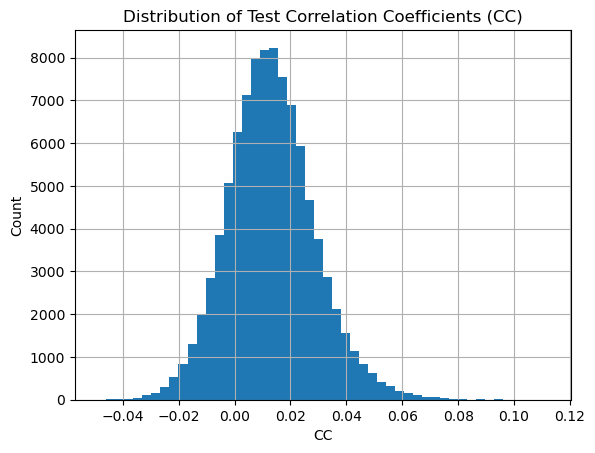

In [6]:
import matplotlib.pyplot as plt

plt.hist(corrs, bins=50)
plt.title("Distribution of Test Correlation Coefficients (CC)")
plt.xlabel("CC")
plt.ylabel("Count")
plt.grid(True)
plt.show()


/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


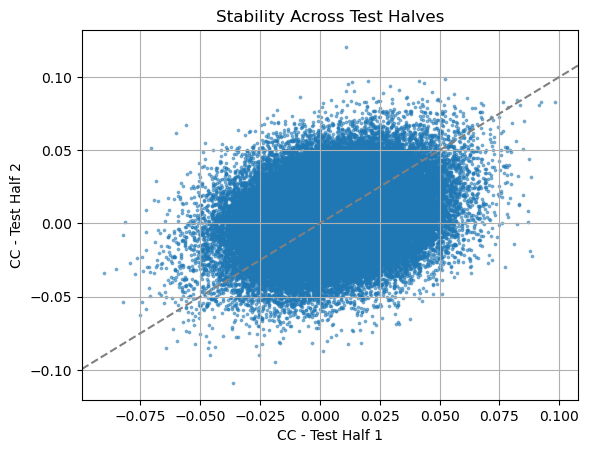

In [11]:
from sklearn.metrics import r2_score

# Assume Y_test_z and model weights are already loaded
# Here, split the test set into two parts and compare voxel-wise correlations

X_test_z = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/inputs_4rdge/glove/X_test_z.npy")   # full test input (shape: n_timepoints, n_features)
Y_test_z = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/inputs_4rdge/glove/Y_test_z.npy")   # full test targets (shape: n_timepoints, n_voxels)
wt2 = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/glove/ridge_weights_0-45000.npy")
wt1 = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/glove/ridge_weights_45000-94000.npy")

wt = np.concatenate([wt1,wt2],axis=1)

n = X_test_z.shape[0]
half = n // 2

# Predict for each half
Y_pred_1 = X_test_z[:half] @ wt
Y_pred_2 = X_test_z[half:] @ wt

Y_true_1 = Y_test_z[:half,:wt.shape[1]]
Y_true_2 = Y_test_z[half:,:wt.shape[1]]

# Correlation per voxel in each half
def voxel_cc(y_true, y_pred):
    return np.array([np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1] for i in range(y_true.shape[1])])

cc_1 = voxel_cc(Y_true_1, Y_pred_1)
cc_2 = voxel_cc(Y_true_2, Y_pred_2)

# Scatter plot to assess stability
plt.scatter(cc_1, cc_2, alpha=0.5, s=3)
plt.xlabel("CC - Test Half 1")
plt.ylabel("CC - Test Half 2")
plt.title("Stability Across Test Halves")
plt.axline((0, 0), slope=1, color='gray', linestyle='--')
plt.grid(True)
plt.show()


In [12]:
# Optional: correlation between the two halves
cc_1 = np.nan_to_num(cc_1)
cc_2 = np.nan_to_num(cc_2)
stability_score = np.corrcoef(cc_1, cc_2)[0, 1]
print("Stability (correlation of voxel CCs across halves):", stability_score)


Stability (correlation of voxel CCs across halves): 0.2531004869624547


# Word2vector Embedding

In [13]:
corrs = np.concatenate([
    np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/word2vec/ridge_test_corrs.npy"),
    np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/word2vec/ridge_test_corrs_5000-45000.npy"),
    np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/word2vec/ridge_test_corrs_45000-94251.npy")
])

In [14]:
mean_cc = np.mean(corrs)
median_cc = np.median(corrs)
top_1_percentile = np.percentile(corrs, 99)
top_5_percentile = np.percentile(corrs, 95)

print("Mean CC:", mean_cc)
print("Median CC:", median_cc)
print("Top 1% CC:", top_1_percentile)
print("Top 5% CC:", top_5_percentile)

Mean CC: 0.01332785070308172
Median CC: 0.012601179323314778
Top 1% CC: 0.05573507560311847
Top 5% CC: 0.04023296479750256


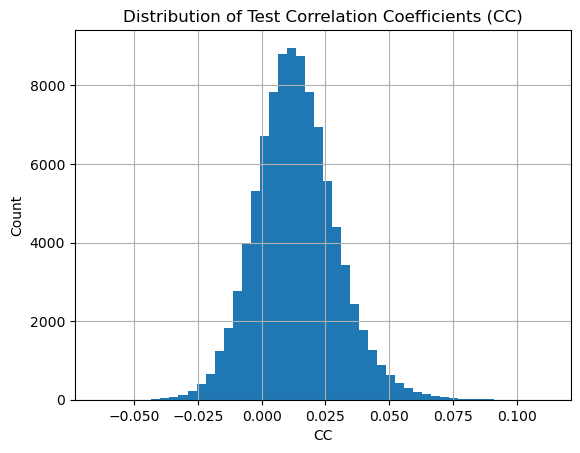

In [15]:

plt.hist(corrs, bins=50)
plt.title("Distribution of Test Correlation Coefficients (CC)")
plt.xlabel("CC")
plt.ylabel("Count")
plt.grid(True)
plt.show()

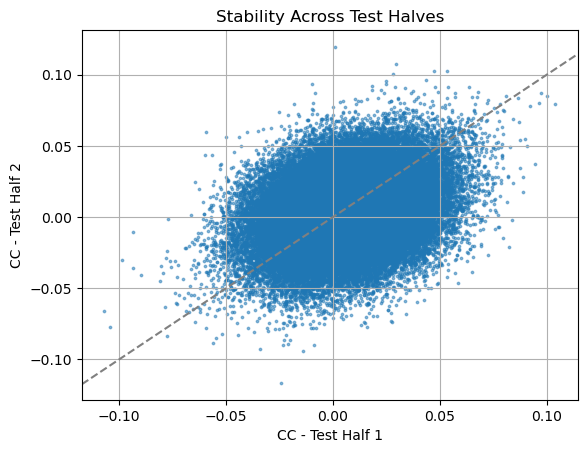

In [16]:
X_test_z = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/inputs_4rdge/word2vec/X_test_z.npy")   # full test input (shape: n_timepoints, n_features)
Y_test_z = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/inputs_4rdge/word2vec/Y_test_z.npy")   # full test targets (shape: n_timepoints, n_voxels)
wt2 = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/word2vec/ridge_weights_5000-45000.npy")
wt1 = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/word2vec/ridge_weights_45000-94251.npy")
wt3 = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/word2vec/ridge_weights.npy")

wt = np.concatenate([wt1,wt2,wt3],axis=1)

n = X_test_z.shape[0]
half = n // 2

# Predict for each half
Y_pred_1 = X_test_z[:half] @ wt
Y_pred_2 = X_test_z[half:] @ wt

Y_true_1 = Y_test_z[:half,:wt.shape[1]]
Y_true_2 = Y_test_z[half:,:wt.shape[1]]

# Correlation per voxel in each half
def voxel_cc(y_true, y_pred):
    return np.array([np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1] for i in range(y_true.shape[1])])

cc_1 = voxel_cc(Y_true_1, Y_pred_1)
cc_2 = voxel_cc(Y_true_2, Y_pred_2)

# Scatter plot to assess stability
plt.scatter(cc_1, cc_2, alpha=0.5, s=3)
plt.xlabel("CC - Test Half 1")
plt.ylabel("CC - Test Half 2")
plt.title("Stability Across Test Halves")
plt.axline((0, 0), slope=1, color='gray', linestyle='--')
plt.grid(True)
plt.show()


In [17]:
cc_1 = np.nan_to_num(cc_1)
cc_2 = np.nan_to_num(cc_2)
stability_score = np.corrcoef(cc_1, cc_2)[0, 1]
print("Stability (correlation of voxel CCs across halves):", stability_score)

Stability (correlation of voxel CCs across halves): 0.27824706249671793


In [2]:
import numpy as np

# BOW Embedding

In [3]:
corrs = np.concatenate([
    np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/bow5/ridge_test_corrs_0-45000.npy"),
    np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/bow5/ridge_test_corrs_45000-95000.npy")
])

In [4]:
mean_cc = np.mean(corrs)
median_cc = np.median(corrs)
top_1_percentile = np.percentile(corrs, 99)
top_5_percentile = np.percentile(corrs, 95)

print("Mean CC:", mean_cc)
print("Median CC:", median_cc)
print("Top 1% CC:", top_1_percentile)
print("Top 5% CC:", top_5_percentile)

Mean CC: 0.0032010110543226203
Median CC: 0.0030059555178585068
Top 1% CC: 0.03492560928746104
Top 5% CC: 0.024578253384977225


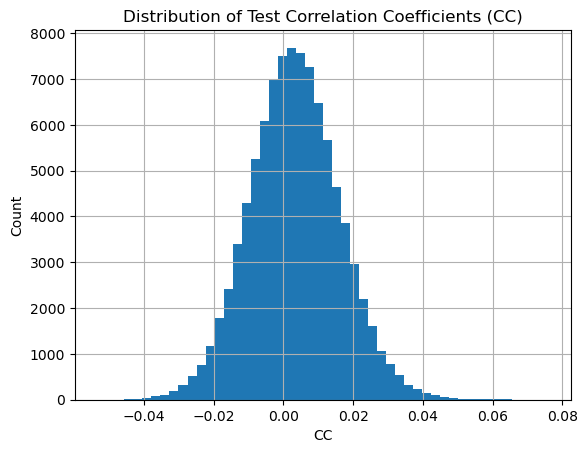

In [6]:
import matplotlib.pyplot as plt

plt.hist(corrs, bins=50)
plt.title("Distribution of Test Correlation Coefficients (CC)")
plt.xlabel("CC")
plt.ylabel("Count")
plt.grid(True)
plt.show()

/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


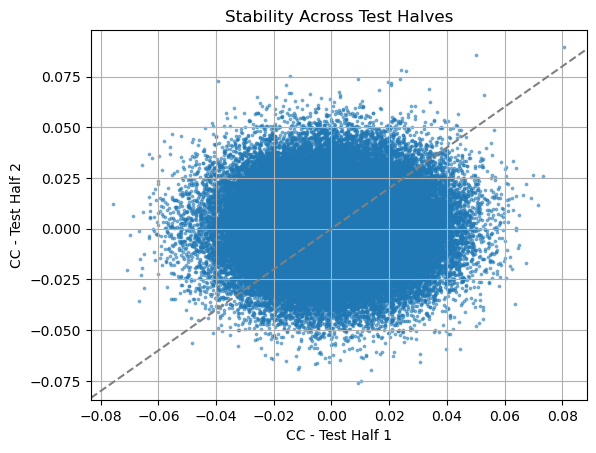

In [7]:
X_test_z = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/inputs_4rdge/bow5/X_test_z.npy")   # full test input (shape: n_timepoints, n_features)
Y_test_z = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/inputs_4rdge/bow5/Y_test_z.npy")   # full test targets (shape: n_timepoints, n_voxels)
wt2 = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/bow5/ridge_weights_0-45000.npy")
wt1 = np.load("/ocean/projects/mth240012p/sapountz/lab3_fmri/results/ridge/ridge_boots/bow5/ridge_weights_45000-95000.npy")

wt = np.concatenate([wt1,wt2],axis=1)

n = X_test_z.shape[0]
half = n // 2

# Predict for each half
Y_pred_1 = X_test_z[:half] @ wt
Y_pred_2 = X_test_z[half:] @ wt

Y_true_1 = Y_test_z[:half,:wt.shape[1]]
Y_true_2 = Y_test_z[half:,:wt.shape[1]]

# Correlation per voxel in each half
def voxel_cc(y_true, y_pred):
    return np.array([np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1] for i in range(y_true.shape[1])])

cc_1 = voxel_cc(Y_true_1, Y_pred_1)
cc_2 = voxel_cc(Y_true_2, Y_pred_2)

# Scatter plot to assess stability
plt.scatter(cc_1, cc_2, alpha=0.5, s=3)
plt.xlabel("CC - Test Half 1")
plt.ylabel("CC - Test Half 2")
plt.title("Stability Across Test Halves")
plt.axline((0, 0), slope=1, color='gray', linestyle='--')
plt.grid(True)
plt.show()

In [8]:
cc_1 = np.nan_to_num(cc_1)
cc_2 = np.nan_to_num(cc_2)
stability_score = np.corrcoef(cc_1, cc_2)[0, 1]
print("Stability (correlation of voxel CCs across halves):", stability_score)

Stability (correlation of voxel CCs across halves): 0.012272464016863643
